# About

Looks at the asymptotic trends of Omega, phi of a single .mat file. Then, plug results into theoretical N-limit equation to see if the global frequency and distribution agrees.

# Libraries

In [1]:
from __future__ import division, print_function

%matplotlib inline
import os
import numpy as np
from numpy.polynomial.polynomial import polyval
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.transforms as tsfm
import math
from math import pi

from lib import *

from IPython.display import clear_output

# Directories

In [2]:
# Data files
name_folder = 'matlab2'
name_file = 'sol30_gain30_2'

# Directory
dir_main = os.getcwd()
dir_mat = os.path.join(dir_main, 'data', name_folder, name_file)

# Import Data

In [3]:
# Import using Scipy
dict_mat = sio.loadmat(dir_mat)

sol = {}
sol['t'] = np.reshape(dict_mat['t'], -1)
sol['y'] = dict_mat['y']
sol['yp'] = dict_mat['yp']

# Parameters
param = {'g': dict_mat['g'][0,0],
        'omega0': dict_mat['omega0'][0,0],
        'a' : 1.0,
        'T' : dict_mat['T'][0,0],
        'gain': dict_mat['gain'][0,0],
        'N': dict_mat['N'][0,0],
        'tf': dict_mat['tf'][0,0],
         'offset': dict_mat['offset'][0,0]
        }

# Process Data

In [4]:
# Asymptotic percentage
asy = 0.1

# Compute the global frequency:
arr_omega = asylib.weight_avg(sol['t'], sol['yp'], asy)
asy_Omega = np.sum(arr_omega) / arr_omega.size

# Get array of asymptotic phases:
arr_lin = asy_Omega*sol['t']
arr_lin = arr_lin[:,None]

arr_diff = sol['y'] - arr_lin
asy_phases = asylib.weight_avg(sol['t'], arr_diff, asy)

asy_inds = np.arange(asy_phases.size)/asy_phases.size
unif_R = asy_phases[-1] - asy_phases[0]
sigma2 = np.var(arr_diff)

# Plot results

Natural frequency = 1
Asymptotic frequency = 0.662792191439512
Asymptotic phase range = 0.36883609062525347


(array([0., 0., 0., 0., 0., 0., 0., 3., 9., 8., 6., 2., 2., 0., 0., 0., 0.,
        0., 0.]),
 array([-0.78539816, -0.70272467, -0.62005118, -0.53737769, -0.4547042 ,
        -0.37203071, -0.28935722, -0.20668373, -0.12401024, -0.04133675,
         0.04133675,  0.12401024,  0.20668373,  0.28935722,  0.37203071,
         0.4547042 ,  0.53737769,  0.62005118,  0.70272467,  0.78539816]),
 <a list of 19 Patch objects>)

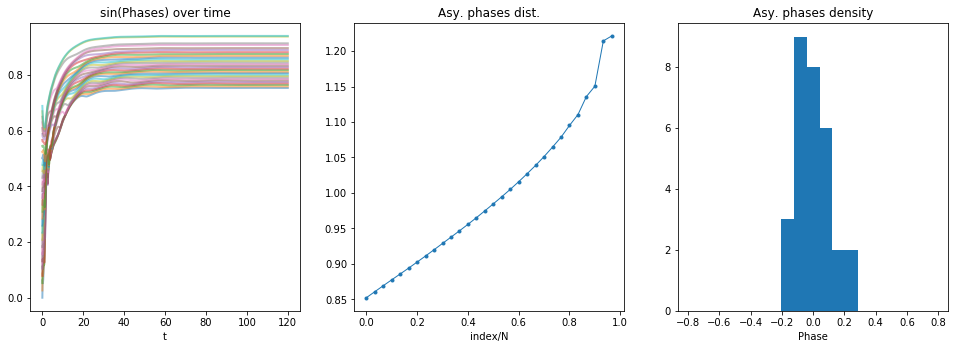

In [29]:
# Print asy values
print('Natural frequency = ' + str(param['omega0']))
print('Asymptotic frequency = ' + str(asy_Omega))
print('Asymptotic phase range = ' + str(unif_R))

# Configure plots
fig, ax = plt.subplots(3, figsize=(15,5))

# [left, bottom, width, height] 
bbox0 = [0.1, 0.1, 0.25, 0.8]
bbox1 = [0.40, 0.1, 0.25, 0.8]
bbox2 = [0.7, 0.1, 0.25, 0.8]

# Set ax positions
ax[0].set_position(bbox0)
ax[1].set_position(bbox1)
ax[2].set_position(bbox2)

# Set titles + axis labels
ax[0].set_title('sin(Phases) over time')
ax[1].set_title('Asy. phases dist.')
ax[2].set_title('Asy. phases density')

ax[0].set_xlabel('t')
ax[1].set_xlabel('index/N')
ax[2].set_xlabel('Phase')

# PLOT
ax[0].plot(sol['t'], np.sin(arr_diff), linewidth=2.0, alpha=0.5)
ax[1].plot(asy_inds, asy_phases, linestyle='-', linewidth=1.0, marker='.')
ax[2].hist(asy_phases - np.mean(asy_phases), np.linspace(-pi/4,pi/4,num=20), density=False)

# Theoretical plots

## Theoretical Frequency and Offsets

Initial phase range = 0.25
Variance = 0.047253454952158096
Global Frequency = 0.662792191439512
0.052232128412279644


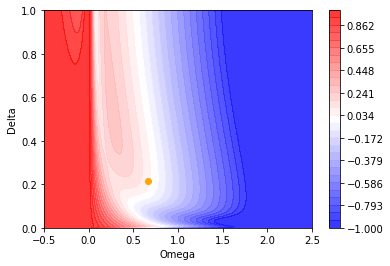

In [6]:
w0 = param['omega0']
g = param['g']
tau0 = param['T']
N_x = 1000

Omega_lin = np.linspace(w0-g, w0+g, num=200)
delta_lin = np.linspace(0, 1, num=200)

delta_mesh, Omega_mesh = np.meshgrid(delta_lin, Omega_lin)

err_mesh = np.zeros(Omega_mesh.shape)
err_fun = lambda u,v: w0 + g*funlib.phase_gauss(u, tau0, N_x, param, v) - u

for k in range(Omega_lin.size):
    for l in range(delta_lin.size):
        err = err_fun(Omega_mesh[k,l], delta_mesh[k,l])
        err = np.max((np.min((err, 1)), -1))
        err_mesh[k,l] = err

# Print error
print("Initial phase range = " + str(param['offset']))
print("Variance = " + str(sigma2))
print("Global Frequency = " + str(asy_Omega))
print(err_fun(asy_Omega, np.sqrt(sigma2)))

# Plot
# fig = plt.figure(figsize=(8,7))
# ax = fig.add_subplot(111, projection='3d')
fig, ax = plt.subplots(1,1)
ax.set_xlabel("Omega")
ax.set_ylabel("Delta")

# ax.plot_wireframe(Omega_mesh, delta_mesh, err_mesh)
# ax.plot_surface(Omega_mesh, delta_mesh, np.zeros(delta_mesh.shape), alpha=0.5)

alpha = 0.8
levels = np.linspace(-1, 1, 30)

CS = ax.contourf(Omega_mesh, delta_mesh, err_mesh, levels, cmap='bwr', alpha=alpha)
ax.autoscale(False)
ax.scatter(np.array([asy_Omega]), np.array([np.sqrt(sigma2)]), color='orange', zorder=1)

cbar = plt.colorbar(CS)

## Theoretical stability

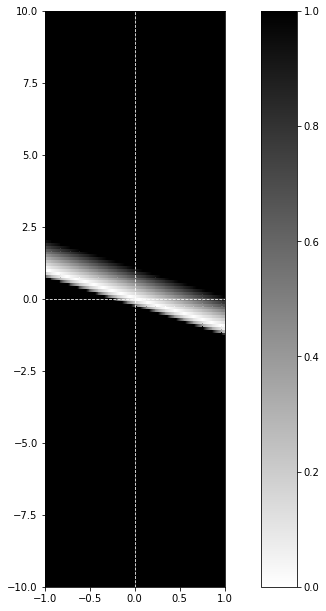

In [20]:
# Set stability state
Omega = 0.6647396083773757
delta2 = 0.047253454952158096

# Define eigenvalue function
eigN_err = lambda z: funlib.eigN_limit2(z, Omega, delta2, tau0, param, steps=50, std=2)

B_u, B_v = 1, 10
N_u, N_v = 200, 200

u_lin = np.linspace(-B_u, B_u, num=N_u)
v_lin = np.linspace(-B_v, B_v, num=N_v)

v_mesh, u_mesh = np.meshgrid(v_lin, u_lin)

eigerr_mesh = np.zeros(u_mesh.shape)

for k in range(u_lin.size):
    for l in range(v_lin.size):
        err = eigN_err(u_mesh[k,l] + v_mesh[k,l])
        eigerr_mesh[k,l] = np.min((np.abs(err), 1))
        
# Transform err_mesh
z_mesh = eigerr_mesh # np.log(1 + err_mesh)

# Normalize
# z_mesh = z_mesh / np.abs(z_mesh).max()

# The bounds for z_array:
abs_max = np.abs(z_mesh).max() #int(abs_max + 1)
z_min, z_max = 0, abs_max

# Set the limits of the plot to the limits of the data
u_min = u_mesh.min()
u_max = u_mesh.max()
v_min = v_mesh.min()
v_max = v_mesh.max()

# Plot
fig, ax = plt.subplots(2, figsize=(5,10))

# [left, bottom, width, height] 
bbox0 = [0.1, 0.1, 0.5, 0.8]
bbox1 = [0.7, 0.1, 0.1, 0.8]

# Set ax positions
ax[0].set_position(bbox0)
ax[1].set_position(bbox1)

c = ax[0].pcolormesh(u_mesh, v_mesh, z_mesh, cmap='binary', vmin=z_min, vmax=z_max) # cmap='RdBu'
ax[0].axis([u_min, u_max, v_min, v_max])
    
# x,y-axis
line_opt = {'linestyle': 'dashed',
            'linewidth': 0.8,
            'color': 'white'
            }

ax[0].axhline(y=0, **line_opt)
ax[0].axvline(x=0, **line_opt)

# Colourbar
fig.colorbar(c, cax=ax[1]) 

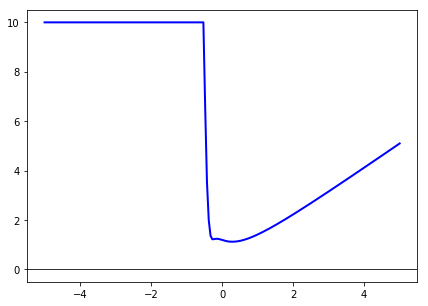

In [25]:
# Cross-sectional view
u_lin = np.linspace(-5, 5, num=200)
v = -1

err_lin = np.zeros(u_lin.size)
for j in range(err_lin.size):
    # err_lin[j] = np.max((np.min((np.abs(eigN_err(u_lin[j] + 1j*v)), 1)),1))
    err_lin[j] = np.min((np.abs(eigN_err(u_lin[j] + 1j*v)), 10))

# PLOT
fig, ax = plt.subplots(1, figsize=(7,5))
ax.plot(u_lin, err_lin, color='blue', linewidth=2.0)
ax.axhline(y=0, color='black', linewidth=0.8)

In [9]:
eigerr_mesh[1,1]
u_mesh[1,1], v_mesh[1,1]

(0.05025125628140704, -9.899497487437186)

In [10]:
eigN_err(1+1j)

(-0.9642309037501291-1.0343093922682671j)

In [11]:
np.min(eigerr_mesh)

0.0